In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from copulapairtrading.utils import find_pairs

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from copulapairtrading.copula import ClaytonCopula

copula = ClaytonCopula()

data = pd.read_csv('../data/price_data.csv', index_col = 0)

# pairs = find_pairs(data)

# with open('../data/pairs.json', 'w') as file:
#     json.dump(pairs, file, indent = 4)

with open('../data/pairs.json', 'r') as file:
    pairs = json.load(file)

In [4]:
copula = ClaytonCopula()
copula.fit(vector = data[pairs[0]])
pdf = copula.pdf(alpha = 1, vector = data[pairs[0]])
marginal_u = copula.marginal_cdf(mask = [True, False], vector = data[pairs[0]])
marginal_v = copula.marginal_cdf(mask = [False, True], vector = data[pairs[0]])
marginal_u.index = pd.to_datetime(marginal_u.index)
marginal_v.index = pd.to_datetime(marginal_v.index)
print(copula.alpha)

1.801830336116682


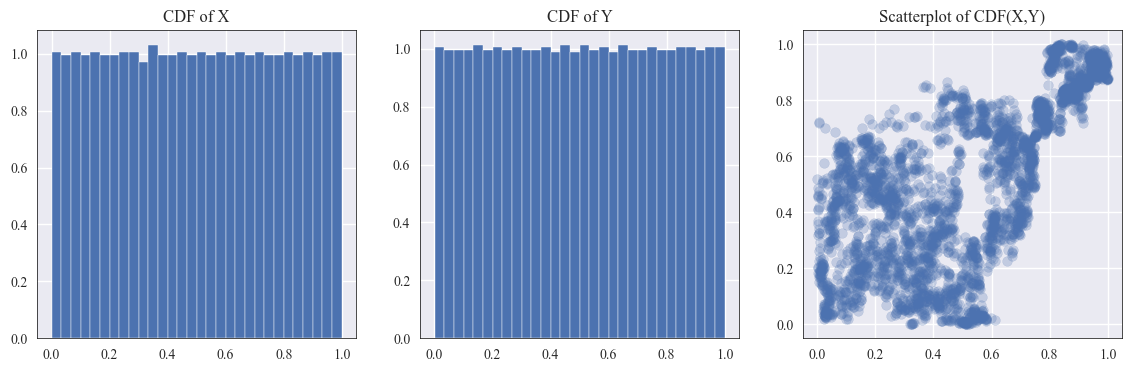

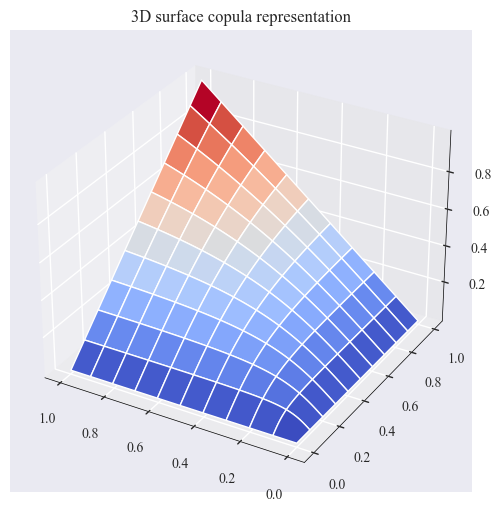

In [5]:
copula.plot_2d()
copula.plot_3d()

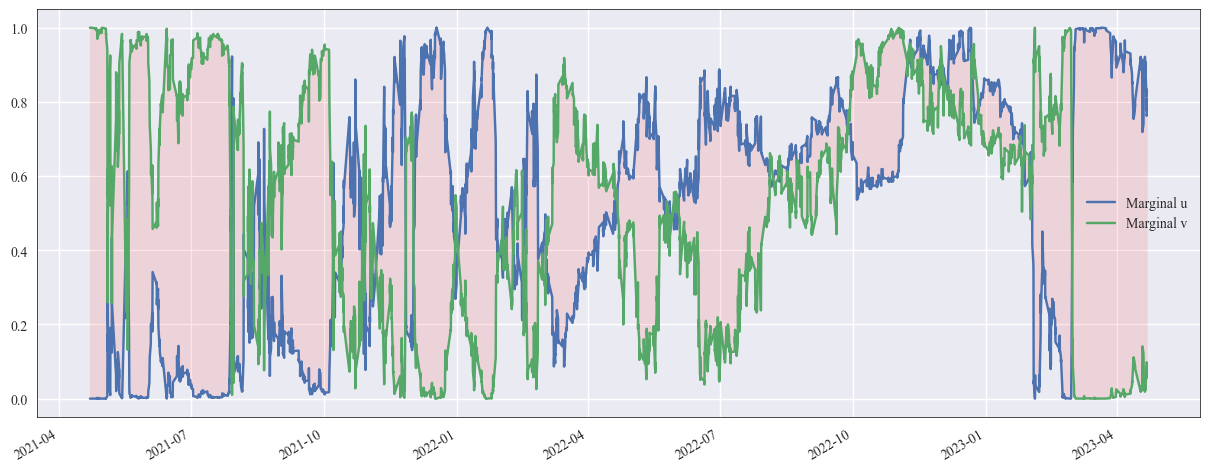

In [6]:
fig, ax = plt.subplots(nrows = 1, figsize = (15, 6))

marginal_u.plot(ax=ax, label = 'Marginal u')
marginal_v.plot(ax=ax, label = 'Marginal v')

ax.fill_between(marginal_u.index, marginal_u, marginal_v, alpha = 0.1, color = 'red');

ax.legend()

In [24]:
from itertools import compress

entry_signals = np.logical_and(marginal_u < 0.05, marginal_v > 0.95)
exit_signals = np.logical_and(marginal_u >= 0.5, marginal_v <= 0.5)

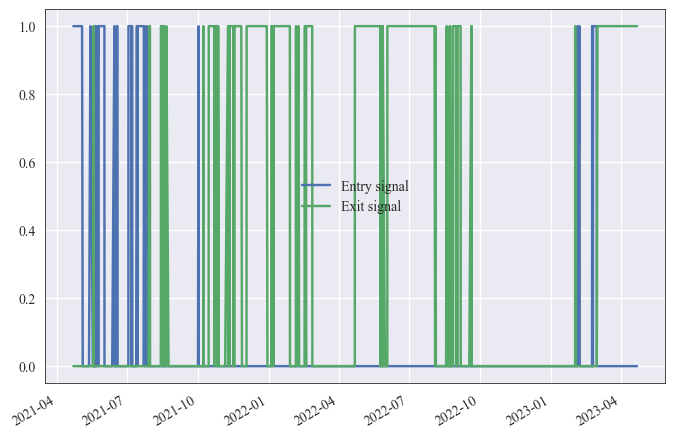

In [26]:
fig, ax = plt.subplots()
entry_signals.astype(int).plot(ax=ax, label = 'Entry signal')
exit_signals.astype(int).plot(ax=ax, label = 'Exit signal')
ax.legend()

In [36]:
find_pairs(data[pairs[0]])

Finding Pairs...: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


[('ADANIENT.NS', 'CIPLA.NS')]

In [37]:
from statsmodels.tsa.stattools import coint
result = coint(data[pairs[0][0]], data[pairs[0][1]], autolag = 'bic', return_results = True)
result

(-3.7173225900701237,
 0.0174066164549779,
 array([-3.89960443, -3.33789445, -3.04567459]))

In [54]:
from copulapairtrading.utils import find_ols_spread
spread = find_ols_spread(data[pairs[0][0]], data[pairs[0][1]])
spread.index = pd.to_datetime(spread.index)

In [71]:
df_trading = pd.concat([-spread, entry_signals, exit_signals], axis=1)
print(df_trading)

                                    0      1      2
2021-04-22 09:15:00+05:30 -508.057674   True  False
2021-04-22 10:15:00+05:30 -500.647328   True  False
2021-04-22 11:15:00+05:30 -494.226594   True  False
2021-04-22 12:15:00+05:30 -491.885373   True  False
2021-04-22 13:15:00+05:30 -488.801600   True  False
...                               ...    ...    ...
2023-04-21 11:15:00+05:30 -193.457913  False   True
2023-04-21 12:15:00+05:30 -199.671007  False   True
2023-04-21 13:15:00+05:30 -193.004142  False   True
2023-04-21 14:15:00+05:30 -198.491403  False   True
2023-04-21 15:15:00+05:30 -198.934365  False   True

[3465 rows x 3 columns]


In [116]:
import pandas as pd

def calculate_pnl(df):
    # Initialize variables
    position = 0
    pnl = 0
    trade_price = 0

    # Create a copy of the input DataFrame
    df_out = df.copy()
    df_out[3] = np.zeros(shape = len(df))
    df_out[4] = np.zeros(shape = len(df))
    df_out[5] = np.empty(shape = len(df))
    df_out[6] = np.zeros(shape = len(df))

    # Loop over the DataFrame rows
    for i in range(len(df)):
        # Check if we have a signal to enter a trade
        if df.iloc[i, 1]:
            # If we are not already holding a position, enter a long position
            if position == 0:
                position = 1
                trade_price = df.iloc[i, 0]
        # Check if we have a signal to exit a trade
        elif df.iloc[i, 2]:
            # If we are holding a long position, exit the position
            if position == 1:
                pnl += df.iloc[i, 0] - trade_price
                position = 0
                trade_price = 0

                # Calculate unrealized pnl and add to pnl
        if position == 1:
            unrealized_pnl = (df.iloc[i, 0] - trade_price) * position

        else:
            unrealized_pnl = 0

        # Append the position and pnl to the output DataFrame
        df_out.iloc[i, 3] = position
        df_out.iloc[i, 4] = pnl
        df_out.iloc[i, 5] = unrealized_pnl
        df_out.iloc[i, 6] = df_out.iloc[i, 4] + df_out.iloc[i, 5]

    df_out.columns = ['Spread', 'Entry Signal', 'Exit Signal', 'Position', 'Realised PnL', 'Unrealised PnL', 'Total PnL']

    return df_out


In [117]:
df_pnl = calculate_pnl(df_trading)

In [119]:
print(df_pnl)

                               Spread  Entry Signal  Exit Signal  Position   
2021-04-22 09:15:00+05:30 -508.057674          True        False       1.0  \
2021-04-22 10:15:00+05:30 -500.647328          True        False       1.0   
2021-04-22 11:15:00+05:30 -494.226594          True        False       1.0   
2021-04-22 12:15:00+05:30 -491.885373          True        False       1.0   
2021-04-22 13:15:00+05:30 -488.801600          True        False       1.0   
...                               ...           ...          ...       ...   
2023-04-21 11:15:00+05:30 -193.457913         False         True       0.0   
2023-04-21 12:15:00+05:30 -199.671007         False         True       0.0   
2023-04-21 13:15:00+05:30 -193.004142         False         True       0.0   
2023-04-21 14:15:00+05:30 -198.491403         False         True       0.0   
2023-04-21 15:15:00+05:30 -198.934365         False         True       0.0   

                           Realised PnL  Unrealised PnL   Total

In [121]:
from copulapairtrading.strategy import run_strat

In [143]:
runs = run_strat(data = data, pairs = pairs)

Running Strat...: 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


In [144]:
l, s = runs[str(pairs[0])]

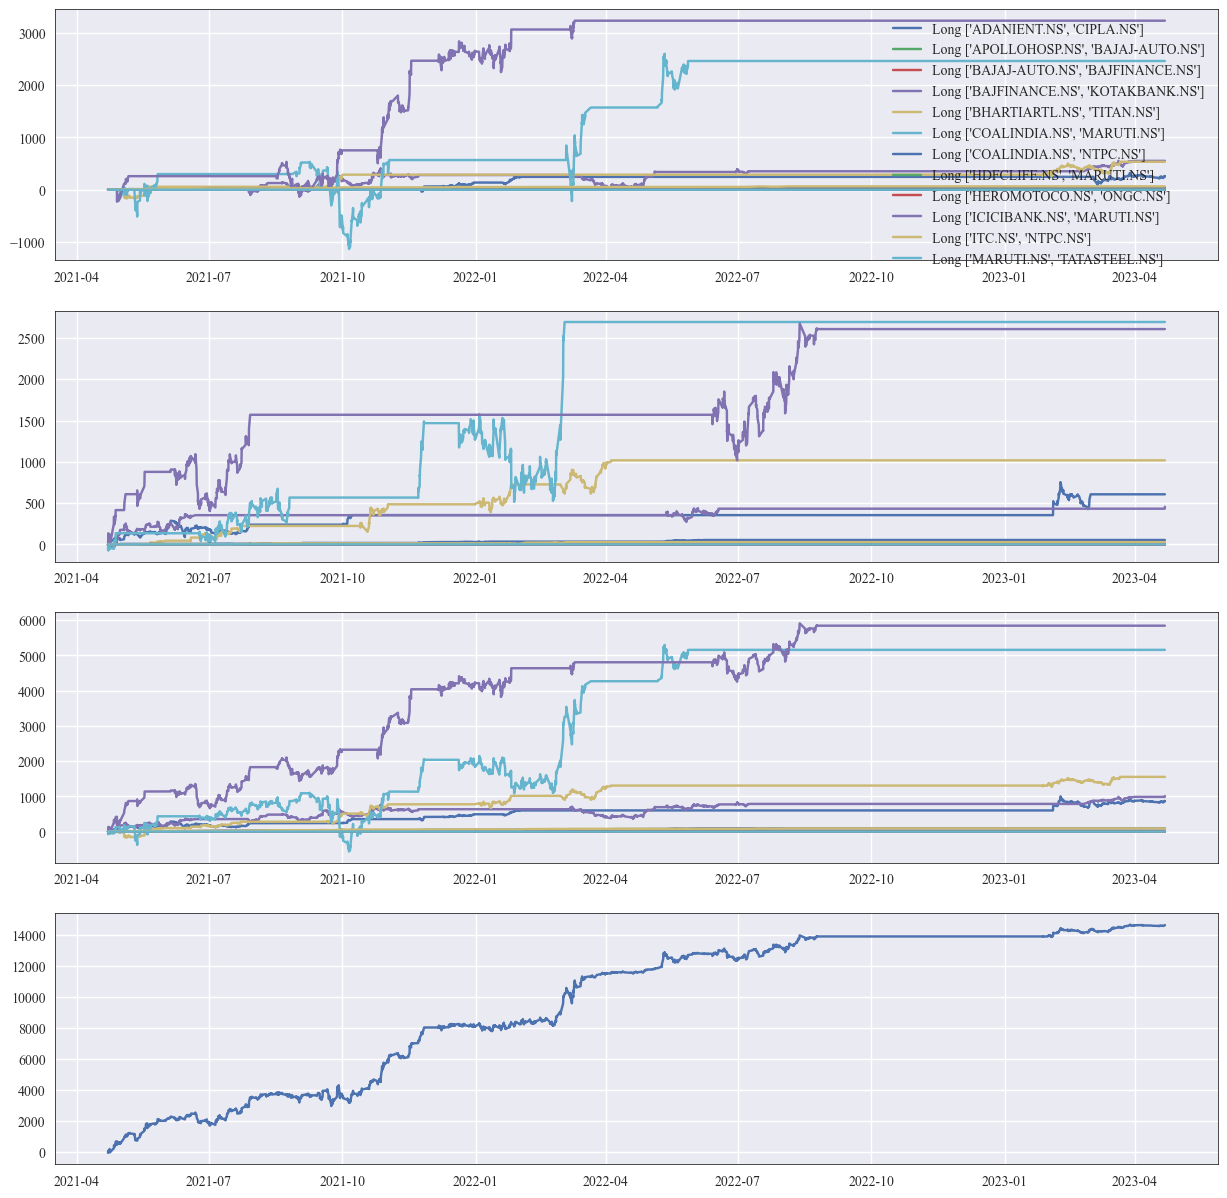

In [145]:
fig, ax = plt.subplots(figsize = (15, 15), nrows = 4)

l, s = runs[str(pairs[0])]
pnl = l['Total PnL'] + s['Total PnL']

for i in range(len(pairs)):

    l, s = runs[str(pairs[i])]
    ax[0].plot(l['Total PnL'], label = f"Long {str(pairs[i])}")
    ax[1].plot(s['Total PnL'], label = f"Short {str(pairs[i])}")
    ax[2].plot(l['Total PnL'] + s['Total PnL'], label = f"Total {str(pairs[i])}")

    if i > 0:
        pnl += l['Total PnL'] + s['Total PnL']

ax[3].plot(pnl)
ax[0].legend()
# ax[1].legend()
# ax[2].legend()